In [1]:
import control
import pyhull
import string
import picos as pic
import cvxopt as cvx
import math
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.integrate
import itertools
import sympy
import sympy.physics.mechanics as me
from matplotlib.patches import Ellipse
from pylab import*

In [2]:
def gam(theta):
    return array([[cos(theta), -sin(theta), 0],
                  [sin(theta), cos(theta), 0],
                  [0, 0, 1]])
def R(theta):
    return array([[cos(-theta), -sin(-theta)],
                  [sin(-theta), cos(-theta)]])

In [201]:
def lqg(x0, xh0, ut, P0, dt, tf):
    
    n_steps = int(tf/dt)
    
    H = array([[1, 0, 0],
               [0, 1, 0]])  # measurment matrix 2*3
    C = H.T @ H
    D = zeros([2,2])
    
    # noise variance
    M = 1*eye(2) # 2*2 
    N = 1*eye(2) 
    
    # initial condition
    P = P0 # covariance
    c_P = P0
    u = ut # input for update
    c_u = ut
    xs = x0
    xh = xh0
    c_xh = xh0
    out_xe = []
    out_xr = []
    out_c_xe = []
    
    # invariant lq
    A_s = dt*array([[1, ut[1], 0],
                    [-ut[1], 1, ut[0]],
                    [0, 0, 1]])
    B = dt*array([[1, 0],
                  [0, 0],
                  [0, 1]])
    St = scipy.linalg.solve_discrete_are(A_s, B, C, D) # riccati solution
    L = -inv(B.T@St@B+D)@B.T@St@A_s # riccati gain
    
    for i in range(n_steps): 
        
        # conventional lq
        At_s = array([[1, 0, -dt*ut[0]*sin(xs[2])],
                      [0, 1, dt*ut[0]*cos(xs[2])],
                      [0, 0, 1]])
        Bt_s = dt*array([[cos(xs[2]), 0],
                         [sin(xs[2]), 0],
                         [0, 1]])
        S = scipy.linalg.solve_discrete_are(At_s, Bt_s, C, D) # riccati solution
        Lt = -inv(Bt_s.T@S@Bt_s+D)@Bt_s.T@S@At_s # riccati gai
        
        # store data
        out_xr.append(xs) # reference trajectory
        out_xe.append(xh) # invariant estimated
        out_c_xe.append(c_xh) # conventional estimated
                
        # Propagate reference
        xs = xs + dt*array([ut[0]*cos(xs[2]), ut[0]*sin(xs[2]), ut[1]])
        
        # iekf
        # Propagate
        A = dt*array([[1, u[1], 0],
                      [-u[1], 1, u[0]],
                      [0, 0, 1]])
        P = A@P@A.T + B@M@B.T
        xh = xh + dt*array([u[0]*cos(xh[2]), u[0]*sin(xh[2]), u[1]])
        
        # conventional ekf
        # Propagate
        At = array([[1, 0, -dt*c_u[0]*sin(c_xh[2])],
                    [0, 1, dt*c_u[0]*cos(c_xh[2])],
                    [0, 0, 1]])
        Bt = dt*array([[cos(c_xh[2]), 0],
                       [sin(c_xh[2]), 0],
                       [0, 1]])
        c_P = At@c_P@At.T + Bt@M@Bt.T
        c_xh = c_xh + dt*array([c_u[0]*cos(c_xh[2]), c_u[0]*sin(c_xh[2]), c_u[1]])


        # simulated measurement
        n = np.random.multivariate_normal(zeros(2), N)
        z = H@xs + n

        
        # iekf update
        K = P@H.T@inv(H@P@H.T+N)
        P = (eye(3)-K@H)@P
        xh = xh + gam(xh[2])@K@R(-xh[2])@(z - H@xh) # x_hat
        
        # conventional ekf update
        c_K = c_P@H.T@inv(H@c_P@H.T + N)
        c_P = (eye(3) - c_K@H)@c_P
        c_xh = c_xh + c_K@(z - H@c_xh) # x_hat
        
        # invariant input update
        u = ut + L@gam(-xs[2])@(xh-xs)
        
        #conventional input update
        c_u = ut + Lt@(c_xh-xs)
        
    xe = np.array(out_xe)
    x = np.array(out_xr)
    c_xe = np.array(out_c_xe)
    return xe, x, c_xe

In [202]:
tf = 5
v = 0.7
r = 5
omega = v /r
x0 = array([0,0,0])
xh0 = array([0,0,-pi])
ut = array([v, omega])
P0 = array([[0.01, 0, 0],[0, 0.01, 0],[0, 0, (90*pi/180)**2]]) # initial covariance?
dt = 0.01

xe, xr, c_xe = lqg(x0, xh0, ut, P0, dt, tf)

(-0.5, 785.5, 429.5, -0.5)

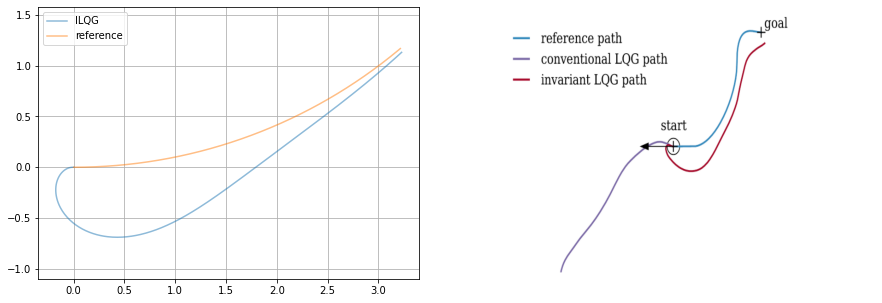

In [203]:
figure(figsize=(15,5))
subplot(121)
plot(xe[:, 0], xe[:, 1], label='ILQG', alpha=0.5)
plot(xr[:, 0], xr[:, 1], label = 'reference', alpha=0.5)
#plot(c_xe[:, 0], c_xe[:, 1], label='LQG', alpha=0.5)
legend(loc=2)
grid()
axis('equal');
subplot(122)
imshow(imread('./images/lqg.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

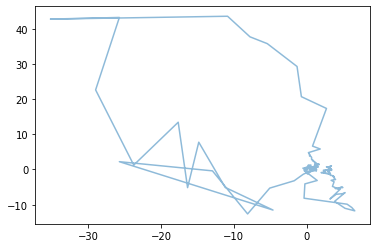

In [204]:
plot(c_xe[:, 0], c_xe[:, 1], label='LQG', alpha=0.5)